# Introduction

< Place holder >



In [1]:
# Imports and parameters

%matplotlib inline 
import xarray as xr, pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime, GeneralFunctions as GF
from sklearn import linear_model
from matplotlib.pyplot import cm
from numba import jit
from scipy import stats
import matplotlib.dates as mdates
import GeneralFunctions as GF
import seaborn as sns
import statsmodels.api as sm
from windrose import WindroseAxes
from statsmodels.stats.outliers_influence import summary_table


# # Manual inspection suggests dubious data quality during this period
st=datetime.datetime(year=2019,month=12,day=27,hour=17)
stp=datetime.datetime(year=2020,month=1,day=2,hour=6)

# Should limit all data to this period
stp_gl=datetime.datetime(year=2020,month=1,day=5,hour=11)

thresh=1 # Filter out hourly-mean winds < this value


/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Functions
def RHO(p,tv):
    
    """
    Computes the air density
    
    Inputs/Outputs (units: explanation): 
    
    In:
        - p (Pa)        : air pressure
        - tv (K or C)   : virtual temperature (can be approximated as T if air is
                          very dry -- low specific humidity)
        
    Out:
    
        - rho (kg/m^3) : air density
        
    """ 
    _rd=287.053 # Gas constant for dry air
    _tv=tv*1.
    if np.nanmax(_tv)<100: _tv +=273.15# NB: C-->K
    if np.nanmax(p)<2000: p*=100 # hPa to Pa
    rho=np.divide(p,np.multiply(_rd,_tv))

    return rho

def CRIT_U(p,tv):
    
    """
    Computes the wind speed required to yield a force of 72 N
    on the "average" man. 
    
    Inputs/Outputs (units: explanation): 
    
    In:
        - p (Pa)       : air pressure
        - tv (K or C)  : virtual temperature (can be approximated as T if air is
                         very dry -- low specific humidity)
        
    Out:
    
        - uc (m/s)     : wind speed to produce force of 72N
        
    """    
    rho=RHO(p,tv)
    # Note: 144 = 2x 72 N; 0.3 = 0.6 drag coef * surface area 0.5 m**2
    uc=np.power(np.divide(144,np.multiply(rho,0.3)),0.5)
    
    return uc


def seas_cycle(ind,n,indata,ncycles=1):
    
    """
    Fits the seasonal cycle using harmonic
    regression.
    
    Inputs/Outputs (units: explanation): 
    
    In:
        - ind          : index variable. 
        - n            : number of obs per cycle
        - indata       : variable to compute seasonal
                         cycle for!
        - ncycles      : frequency 
        
    Out:
    
        - uc (m/s)     : seasonal cycle for indata
        
    """  
    y=indata.values[:]
    reg = linear_model.LinearRegression() 
    ind = 2*np.pi*(ind/np.float(n)) 
    idx = ~np.isnan(y)
    cosines=np.zeros((len(ind),ncycles))*np.nan
    sines=np.zeros(cosines.shape)*np.nan
    for i in np.arange(1,ncycles+1):
        cosines[idx,np.int(i-1)]=np.cos(ind[idx]*i)
        sines[idx,np.int(i-1)]=np.sin(ind[idx]*i)
    X = np.column_stack((cosines,sines));
    reg.fit(X[idx,:], y[idx]) 
    sim = reg.predict(X)
    return sim

def himDate(datecol,hourcol,verb=False):
    
    """
    Simply iterates over datestrings (day/month/year)
    and returns a vector of datetimes
    
    In:
        - datecol     : of form "day/month/year"
        - hourcol     : decimal form
        - verb        : if verb, print outcome from except
        
    Out:
    
        - uc (m/s)    : datetime.datetime
        
    """
    date=[]
    for i in range(len(datecol)):
        try:
            day=np.int(datecol.values[i][:2])
            month=np.int(datecol.values[i][3:5])
            year=np.int(datecol.values[i][6:])
            hour=np.int(np.round(hourcol.values[i])); 
            if hour == 0: hour= 6# Do this to force to middle of calendar day (needed if no hour recorded)
            d=datetime.datetime(year=year,month=month,day=day,hour=hour)
            
        except: 
            d=np.nan
            if verb:
                print datecol.values[i]

        date.append(d)
        
    return date
        
    
def match_winds(dates,wind_df,stat,tol_hours,shift_time=0):
            
        """
        Iterate over all dates in 'dates' and
        find all wind observations within +/- 
        (tol_hours+shift_time)

        In:
            - dates     : datetime object for which to find winds
            - wind_df   : series with winds (and time index)
            - stat      : statistic to compute (string -- from numpy)
            - tol_hours : stat wind taken for +/- this many hours 
            - shift_time: n hours to adjust to the same time zone
                         (will be added on to the dates)

        Out:

            - df_out    : dataframe with max wind within tol_hours 
                          of each date in dates 

        """
        # Substitutions
        f=getattr(np,stat)
        wtime=wind_df.index
        delta=datetime.timedelta(hours=tol_hours)
        out=np.zeros(len(dates))*np.nan
        count=0
        for d in dates:
            if isinstance(d,float): count +=1; continue
            di=d+datetime.timedelta(hours=shift_time)
            idx=np.logical_and(wtime>=(di-delta),wtime<=(di+delta))
            if np.sum(idx)>0:
                out[count]=f(wind_df.loc[idx])
            count+=1
            
        out=pd.Series(out,index=dates)
        return out
    
    
    
def clusters(dates,threshold,max_ht):
 
    """
    Iterate over all dates in 'dates' and
    find all wind observations within +/- 
    (tol_hours+shift_time)

    In:
        - dates     : datetime object 
        - threshold : ndays: all dates within this ndays of another
                      will be treated as non-unique
        - max_ht    : maximum elevation reached by the climbers


    Out:

        - id        : ids of the different clusters
        - centre    : centre points/dates for the clusters
    """
    dates=np.array(dates)
    const=24*60**2
    id=np.zeros(len(dates))*np.nan
    centre=[]
    idi=0
    count=0
    for i in range(len(dates)):
        if count == 0: id[count]=idi; count +=1; continue       
        # create temporary indexing var
        inds=np.arange(len(dates))
        # Drop var for this iteration
        inds=inds[inds != i]
        # Difference with all others
        delta=dates[i]-dates[inds]
        # Take min. 
        dm=np.abs([ii.total_seconds()/const for ii  in delta]); 
        
        # If yes, we have another match somewhere     
        if np.min(dm) <=threshold:          
            nbs = id[inds]
            nbs = nbs[dm<=threshold]
            nbs_valid=nbs[~np.isnan(nbs)]
            # Have a neighbour already allocated 
            # an id
            if len(nbs_valid)>=1:
                id[count]=nbs_valid[0]
            # Neighbours, but no id yet
            else: 
                idi+=1
                id[count] = idi       
                
        else:            
            idi+=1
            id[count] = idi
        count +=1
    udates=[]  
    meta={}
    maxs={}
    for i in np.unique(id):
        a=np.min(dates[id==i])
        b=np.max(dates[id==i])
        mid=a+(b-a)/2
        udates.append(mid)
        meta[mid]=dates[id==i]
        maxs[mid]=np.max(max_ht[id==i])
        
        
    return udates, meta, maxs

# Circular statistics 
def circ_stat(series,wdir,span,stat,res):
    
    """
    Info to follow 
    """
    
    # Radians
    rad=np.radians(wdir)
    thresh=np.radians(span)
    circ=2*np.pi
    
    # Associate function - making sure it's 'nan-compatible'
    stat="nan"+stat
    f = getattr(np,stat)
    
    # preallocate
    #out=np.zeros(len(series))*np.nan
    uang=np.radians(np.arange(1,360,res))
    out=np.zeros(len(uang))
    count=0
    for ii in uang:
        delta=np.min(np.column_stack((circ-abs(rad-ii),np.abs(rad-ii))),axis=1)
        logi=delta<=thresh
        out[count]=f(series[logi])
        count+=1
        
    uang=np.degrees(uang)
    return uang,out


def circ_correl(series1,series2,wdir,span,res):
    
    """
    Info to follow 
    """
    
    # Radians
    rad=np.radians(wdir)
    thresh=np.radians(span)
    circ=2*np.pi
    
    # preallocate
    uang=np.radians(np.arange(1,360,res))
    out=np.zeros(len(uang))
    nanidx=np.logical_and(~np.isnan(series1),~np.isnan(series2))
    count=0
    for ii in uang:
        delta=np.min(np.column_stack((circ-abs(rad-ii),np.abs(rad-ii))),axis=1)
        #delta=np.array([ circ - np.min([circ-abs(jj-ii),abs(jj-ii)]) for jj in rad])
        logi=delta<=thresh
        logi=np.logical_and(logi,nanidx)
        out[count]=np.corrcoef(series1[logi],series2[logi])[0,1]
        count+=1
        
    uang=np.degrees(uang)
    return uang,out
            

In [3]:
# Import the reanalysis
fr="/home/lunet/gytm3/Everest2019/Research/Weather/Data/SouthCol_interpolated.nc"
r=xr.open_dataset(fr).to_dataframe()
ur=r["ws"]
u_wnd=r["u_wnd"]
v_wnd=r["v_wnd"]
tr=r["temp"]-273.15
pr=r["press"]

# Repeat with the summit data -- so that we can assess how much windier it is. 
fr2="/home/lunet/gytm3/Everest2019/Research/Weather/Data/Summit_interpolated.nc"
r2=xr.open_dataset(fr2).to_dataframe()
ur2=r2["ws"]
tr2=r2["temp"]-273.15
pr2=r2["press"]

# What's the ratio between summit and South Col?
print("Summit is %.4f times windier than the South Col" %(np.mean(ur2)/np.mean(ur)))

# Ditto observations -- incl. filtering and alocation
fo="/home/lunet/gytm3/Everest2019/AWS/Logging/south_col.csv"
o=pd.read_csv(fo,parse_dates=True,index_col=0)
for i in o.columns: o[i]=o[i].astype(np.float)
o=o.loc[o.index<=stp_gl]
u=o["WS_AVG_2"]
ug=o["WS_MAX_2"]
t=o["T_HMP"]
p=o["PRESS"]
idx=np.logical_and(u>thresh,ug>thresh) # very minimal filter that removes wind during v. slack conditions
idx=np.logical_and(idx,~np.logical_and(u.index>=st,u.index<=stp))
print("Keeping %.1f%% of data"%((np.sum(idx)/np.float(len(idx)))*100))
u.values[~idx]=np.nan
ug.values[~idx]=np.nan
wdir_short=o["WDIR"]#Take these because wdir from second sensor not working
u_short=o["WS_AVG"] # Ditto -- and expanded: needed for wind rose
idx=np.logical_and(u_short.index<datetime.datetime(year=2019,month=12,day=15),u_short>thresh) 
u_short=u_short.loc[idx]
wdir_short=wdir_short.loc[idx]

# Extract overlapping reanalysis wind
ur_sub=ur.loc[ur.index.isin(u.index)]
u_sub=u.loc[u.index.isin(ur.index)]
ug_sub=ug.loc[u.index.isin(ur.index)]

# Extract overlapping temp 
tr_sub=tr.loc[tr.index.isin(t.index)]
t_sub=t.loc[u.index.isin(tr.index)]

# Extract overlapping pressure
pr_sub=pr.loc[pr.index.isin(p.index)]
p_sub=p.loc[p.index.isin(pr.index)]

# Quickly check the mean threshold for dangerous inds at the summit
uc2=CRIT_U(pr2,tr2); print("Mean summit threshold = %.2f" % np.mean(uc2))


Summit is 1.2335 times windier than the South Col
Keeping 91.3% of data
Mean summit threshold = 31.87


Peak gust in May, 2019: 29.79
Mean abs error = 3.01
MAE is 14.9 % of the mean


/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice


0.0
0.975783245268


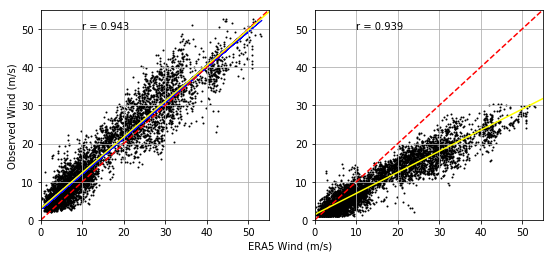

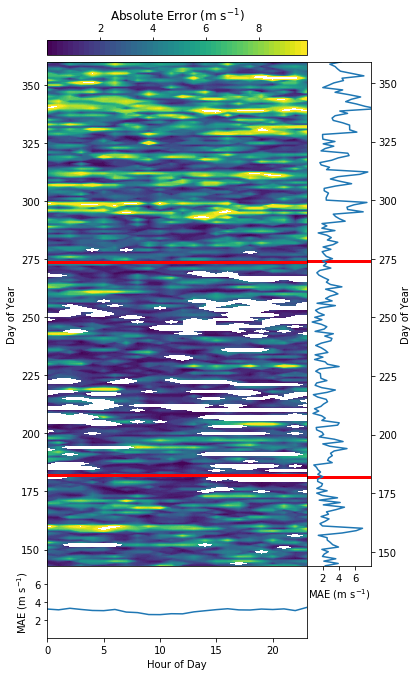

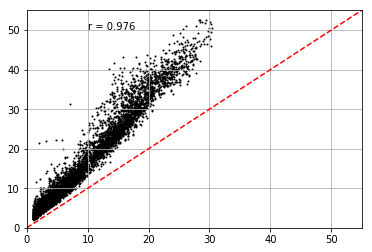

In [25]:
# Comparisons 
# Gusts
fig,ax = plt.subplots(1,2)
fig.set_size_inches(9,4)
x=np.linspace(0,60)
idx=np.logical_and(~np.isnan(ur_sub),~np.isnan(ug_sub))
rug=np.corrcoef(ur_sub[idx],ug_sub[idx])[0,1]
ax.flat[0].scatter(ur_sub,ug_sub,s=1,color='k')
ax.flat[0].grid()
ax.flat[0].plot(x,x,color='red',linestyle="--")
ax.flat[0].set_xlim([0,55])
ax.flat[0].set_ylim([0,55])
ax.flat[0].text(10,50,"r = %.3f"%rug)
# Means
idx=np.logical_and(~np.isnan(ur_sub),~np.isnan(u_sub))
ru=np.corrcoef(ur_sub[idx],u_sub[idx])[0,1]
ax.flat[1].scatter(ur_sub,u_sub,s=1,color='k')
ax.flat[1].grid()
ax.flat[1].plot(x,x,color='red',linestyle="--")
ax.flat[1].set_xlim([0,55])
ax.flat[1].set_ylim([0,55])
ax.flat[1].text(10,50,"r = %.3f"%ru)

# Regressions and reconstructions 
pu=np.polyfit(ur_sub[idx],u_sub[idx],1)
pug=np.polyfit(ur_sub[idx],ug_sub[idx],1)
# Reconstruct
u_recon=pd.Series(np.polyval(pu,ur),index=r.index)
ug_recon=pd.Series(np.polyval(pug,ur),index=r.index)

# Peak gusy during May, 2019
peak_may_2019=ug_recon.loc[np.logical_and(\
             np.logical_and(ug_recon.index.month==5,ug_recon.index.year==2019),\
                                          ug_recon.index.day==3)]
print("Peak gust in May, 2019: %.2f" % np.max(peak_may_2019))

# Plots
ax.flat[0].plot(x,np.polyval(pug,x),color='yellow')
ax.flat[1].plot(x,np.polyval(pu,x),color='yellow')

# Regression #2 -- this time to include sig for params
Y = ug_sub[idx]
X = sm.add_constant(ur_sub[idx])
model = sm.OLS(Y,X)
results = model.fit()
_st, _data, _ss2 = summary_table(results, alpha=0.05)
predict_mean_ci_low, predict_mean_ci_upp = _data[:,4:6].T
ax.flat[0].fill_between(ur_sub[idx],predict_mean_ci_low,predict_mean_ci_upp,color="blue")

# Summarise 
mae=np.nanmean(np.abs(ug_sub[idx]-np.polyval(pug,ur_sub[idx])))
print("Mean abs error = %.2f"%mae)
print("MAE is %.1f %% of the mean" %(mae/np.mean(ug_recon)*100))

# Tidy plot
ax.flat[0].set_ylabel("Observed Wind (m/s)")
#ax.flat[0].set_xlabel("ERA-5 (m/s)")
#ax.flat[1].set_xlabel("ERA-5 (m/s)")
plt.subplots_adjust(bottom=0.15)
fig.text(0.51, 0.05, 'ERA5 Wind (m/s)', ha='center')
#plt.tight_layout()
fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Reanaly_Scatter.tiff",dpi=600)


# Simple MAE for matrix plot
ugr_sub=np.polyval(pug,ur_sub[idx])
maes=np.abs(ugr_sub-ug_sub[idx])
maes=pd.Series(maes,index=ug_sub[idx].index)
doys=maes.index.dayofyear
udoys=np.unique(doys)[1:-1]
hours=maes.index.hour
uhours=np.unique(hours)
out=np.zeros((len(udoys),len(uhours)))*np.nan
out_hour=np.zeros(len(uhours))*np.nan
out_doy=np.zeros(len(udoys))*np.nan
row=0
invalid=0
for d in udoys:
    col=0
    for h in uhours:
        idxi=np.logical_and(doys==d,hours==h)
        out[row,col]=np.nanmean(maes.loc[idxi])
        if d == np.min(udoys):
            out_hour[col]=np.nanmean(maes.loc[hours==h])
#            out_hour[col]=out_hour[col]/np.nanmean(ug_sub[idx][idxi])*100.
        col+=1
        if not idx.any():
            invalid+=1
    out_doy[row]=np.nanmean(maes.loc[doys==d])
#    out_doy[row]=out_doy[row]/np.nanmean(ug_sub[idx][idxi])*100
    row+=1
    
print invalid/np.float(len(ug))

fig = plt.figure()
fig.set_size_inches(6,10)
ax1 = fig.add_axes([0.1, 0.15, 0.6, 0.70],xticks=([]))
ax2 = fig.add_axes([0.1, 0.05, 0.6, 0.1])
ax3 = fig.add_axes([0.7, 0.15, 0.15, 0.70])
cax = fig.add_axes([0.1, 0.86, 0.6, 0.02])
ax3.yaxis.tick_right()

levs=np.linspace(np.nanmin(out),np.nanpercentile(out,98),50)
c=ax1.contourf(uhours,udoys,out,levels=levs,cmap="viridis")
ax1.axhline(182,color='red',linewidth=3)
ax1.axhline(274,color='red',linewidth=3)
ax1.set_ylabel("Day of Year")

ax2.plot(uhours,out_hour)
ax2.set_ylim(0,8)
ax2.set_yticks([2,4,6])
ax2.set_xlim([0,23])
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("MAE (m s$^{-1}$)")
ax3.axhline(182,color='red',linewidth=3)
ax3.axhline(274,color='red',linewidth=3)
ax3.set_xlabel("MAE (m s$^{-1}$)")

ax3.plot(out_doy,udoys)
ax3.set_xlim(0,8)
#ax3.xaxis.tick_top()
ax3.set_xticks([2,4,6])
ax3.set_ylim([np.min(udoys[1:-1]),np.max(udoys[:-1])])
ax3.set_ylabel("Day of Year")
ax3.yaxis.set_label_position("right")

c=plt.colorbar(c,cax=cax,orientation="horizontal",ticks=[0,2,4,6,8])
cax.xaxis.tick_top()
cax.set_title("Absolute Error (m s$^{-1}$)",pad=20)

fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Error_details.png",dpi=600)


# Observed data -- some analysis
fig,ax=plt.subplots(1,1)
r0=np.corrcoef(ug_sub[idx],u_sub[idx])[0,1]; print(r0)
ax.scatter(u_sub,ug_sub,s=1,color='k')
ax.plot(x,x,color='red',linestyle="--")
ax.set_xlim([0,55])
ax.set_ylim([0,55])
ax.text(10,50,"r = %.3f"%r0)
ax.grid()

# Wdir from the reanalysis
wdir=GF.calc_wdir(u_wnd,v_wnd)

# Gust factors
gfs=ug_sub/u_sub

#

# Read in the horizon angles
hang=np.loadtxt("/home/lunet/gytm3/Everest2019/Research/Weather/Data/horz.txt")


In [5]:
predict_mean_ci_low

array([ 14.45429869,  14.99195385,  15.27674965, ...,  24.49967908,
        24.82196211,  25.36288435])

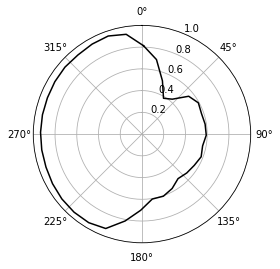

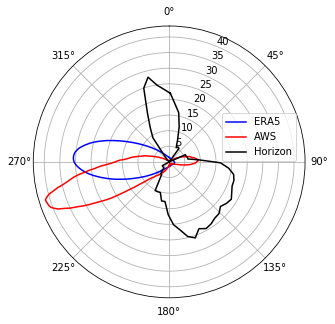

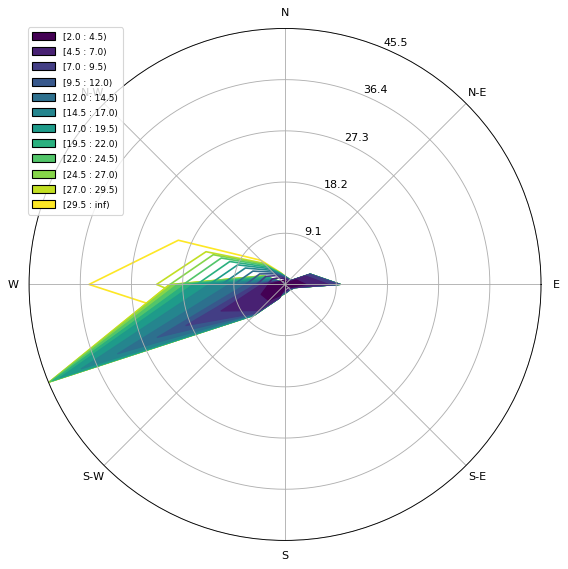

In [6]:
# Gust factors
gfs=ug_sub/u_sub

# Read in the horizon angles
hang=np.loadtxt("/home/lunet/gytm3/Everest2019/Research/Weather/Data/horz.txt")


# Correlations between rug_sub and ug_sub
wdir_sub=wdir.loc[wdir.index.isin(ug_sub.index)]
angs,rdir=circ_correl(ug_sub,ur_sub,wdir_sub,45,10.)
rdir_plot=np.zeros((len(angs)+1,2))
rdir_plot=np.zeros((len(angs)+1,2))
rdir_plot[:-1,0]=angs;rdir_plot[-1,0]=angs[0]
rdir_plot[:-1,1]=rdir;rdir_plot[-1,1]=rdir[0]
fig=plt.figure()
ax=plt.subplot(111,projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.plot(np.radians(rdir_plot[:,0]),rdir_plot[:,1],color="black",label="Correlation")
ax.set_ylim(0,1)
fig.set_size_inches(4,4)
fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Wind_dir_correl.png",dpi=300)

# Gust factors as f(dir):
# GFS wind dirs:
test=np.ones(len(wdir))
angs,mu=circ_stat(test,wdir,10,"sum",1.)
mu/=np.float(len(wdir))/100.

# Obs wind dirs:
test=np.ones(len(wdir_short))
angs_o,mu_o=circ_stat(test,wdir_short,10,"sum",1.)
mu_o/=np.float(len(wdir_short))/100.

# Prep horizon angles for plotting
hangs_plot=np.zeros((len(hang)+1,(hang.shape[1])))
hangs_plot[:-1,:]=hang[:,:]
hangs_plot[-1,:]=hang[0,:]

# Prep gfs for plotting
angs_plot=np.zeros((len(angs)+1,2))
angs_plot[:-1,0]=angs[:]; angs_plot[:-1,1]=mu[:]
angs_plot[-1,0]=angs[0]; angs_plot[-1,1]=mu[0]

# Ditto for the obs
angs_plot_o=np.zeros((len(angs)+1,2))
angs_plot_o[:-1,0]=angs_o[:]; angs_plot_o[:-1,1]=mu_o[:]
angs_plot_o[-1,0]=angs_o[0]; angs_plot_o[-1,1]=mu_o[0]

fig=plt.figure()
ax=plt.subplot(111,projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.plot(np.radians(angs_plot[:,0]),angs_plot[:,1],color="blue",label="ERA5")
ax.plot(np.radians(angs_plot_o[:,0]),angs_plot_o[:,1],color="red",label="AWS")

#ax.set_ylim(1.7,2.9)
#ax.set_ylabel("Gust factor")

#ax=plt.subplot(212,projection='polar')
#ax.set_theta_direction(-1)
#ax.set_theta_direction(-1)
#ax.set_theta_zero_location("N")
ax.plot(np.radians(hangs_plot[:,0]),hangs_plot[:,1],color="black",label="Horizon")
fig.legend(loc='upper right',bbox_to_anchor=(0.835, 0.60))

#ax.set_ylabel("Horizon angle (degrees)",rotation=45)
#
fig.set_size_inches(5,5)
fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Wind.png",dpi=300)

#ax.set_ylabel("Gust factor")



idx=np.logical_and(~np.isnan(wdir_short),~np.isnan(u_short))
ax = WindroseAxes.from_ax()
ax.contourf(wdir_short[idx], u_short[idx],normed=True,bins=np.arange(2,30,2.5),cmap=cm.viridis)
ax.contour(wdir, ur,normed=True,bins=np.arange(2,30,2.5),cmap=cm.viridis)

#ax.contour(wd, ws, bins=np.arange(0, 8, 1), colors='black')
ax.set_legend(loc=2)

f=plt.gcf(); f.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Windrose.png",dpi=300)

In [7]:
gfs

2019-05-22 06:00:00    1.723502
2019-05-22 07:00:00    1.572737
2019-05-22 08:00:00    1.651974
2019-05-22 09:00:00    1.666367
2019-05-22 10:00:00    1.868233
2019-05-22 11:00:00    1.819905
2019-05-22 12:00:00    2.022315
2019-05-22 13:00:00    2.467066
2019-05-22 14:00:00    2.601472
2019-05-22 15:00:00    3.527337
2019-05-22 16:00:00    5.132117
2019-05-22 17:00:00         NaN
2019-05-22 18:00:00    2.299762
2019-05-22 19:00:00    2.473397
2019-05-22 20:00:00         NaN
2019-05-22 21:00:00    5.732236
2019-05-22 22:00:00    2.024108
2019-05-22 23:00:00    2.270037
2019-05-23 00:00:00    1.583263
2019-05-23 01:00:00    1.593268
2019-05-23 02:00:00    1.521799
2019-05-23 03:00:00    2.047143
2019-05-23 04:00:00    1.560886
2019-05-23 05:00:00    1.663379
2019-05-23 06:00:00    1.676778
2019-05-23 07:00:00    1.951795
2019-05-23 08:00:00    1.734458
2019-05-23 09:00:00    1.746135
2019-05-23 10:00:00    1.877493
2019-05-23 11:00:00    2.519618
                         ...   
2019-12-

Frac above (mean) = 0.89
Frac above (gust) = 23.10
1.96 st error gust: 7.703
1.96 st error mean: 4.712


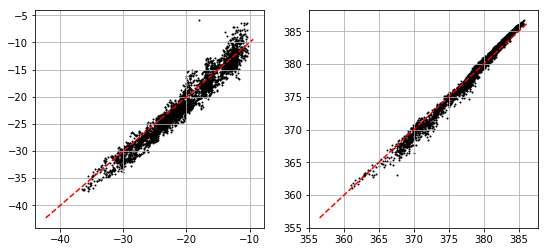

In [8]:
# Comparisons -- repeat temp and pressure 
# Temp
fig,ax = plt.subplots(1,2)
fig.set_size_inches(9,4)
idx=np.logical_and(~np.isnan(tr_sub),~np.isnan(t_sub))
idx=np.logical_and(idx,u_sub>5.) # Filter out light winds 
x=np.linspace(np.min([np.nanmin(t),np.nanmin(tr)]),np.min([np.nanmax(t),np.nanmax(tr)]))
ax.flat[0].scatter(tr_sub[idx],t_sub[idx],s=1,color='k')
ax.flat[0].plot(x,x,color='red',linestyle='--')
ax.flat[0].grid()
pt=np.polyfit(tr_sub[idx],t_sub[idx],1)

# Pressure 
idx=np.logical_and(~np.isnan(pr_sub),~np.isnan(p_sub))
x=np.linspace(np.min([np.nanmin(p),np.nanmin(pr)]),np.min([np.nanmax(p),np.nanmax(pr)]))
ax.flat[1].scatter(pr_sub[idx],p_sub[idx],s=1,color='k')
ax.flat[1].plot(x,x,color='red',linestyle='--')
ax.flat[1].grid()
pp=np.polyfit(pr_sub[idx],p_sub[idx],1)

# Reconstruct
t_recon=pd.Series(np.polyval(pt,tr),index=tr.index)
p_recon=pd.Series(np.polyval(pp,pr),index=pr.index)

# Get errors
idx=np.logical_and(~np.isnan(ur_sub),~np.isnan(u_sub))
sy,lower,best,upper,dummy=GF.pred_intervals(ur_sub[idx],ug_sub[idx],ur)
lower=pd.Series(lower,ug_recon.index)
upper=pd.Series(upper,ug_recon.index)


# Create climatology 
mean=seas_cycle(ug_recon.index.dayofyear,365.25,ug_recon[:],ncycles=5)
mean=pd.Series(mean,ug_recon.index)

# Compute dyanmic wind speed threshold
ur_c=CRIT_U(p_recon,t_recon)
ur_c=pd.Series(ur_c,ur_c.index)

# Compute > thresh
du_r=pd.Series(u_recon>ur_c,index=u_recon.index)
dug_r=pd.Series(ug_recon>ur_c,index=u_recon.index)

# Summarise some stats
n=np.float(len(dug_r))
print("Frac above (mean) = %.2f"%(np.sum(du_r)/n*100.))
print("Frac above (gust) = %.2f"%(np.sum(dug_r)/n*100.))

# Summarise residuals
resid_g=np.polyval(pug,ur_sub)-ug_sub
resid=np.polyval(pu,ur_sub)-u_sub
print("1.96 st error gust: %.3f"%(1.96*np.std(resid_g)))
print("1.96 st error mean: %.3f"%(1.96*np.std(resid)))

In [9]:
wdir_short.loc[np.isnan(wdir_short)]

Series([], Name: WDIR, dtype: float64)

In [10]:
# Monthly percentiles
pctls=[5.,50.,75,90.,99.]
mon_stats={}
ncycles=4
for p in pctls:
    scratch=ug_recon.groupby(ug_recon.index.dayofyear).quantile(p/100.)
    out=seas_cycle(scratch.index,365.25,scratch,ncycles)
    mon_stats[p]=out
mon_stats=pd.DataFrame(mon_stats,index=np.arange(1,len(out)+1))
    
# Monthly probability of exceedance 
month_dug=dug_r.groupby(dug_r.index.dayofyear).mean()*100.
month_dug_s=\
pd.Series(seas_cycle(month_dug.index,365.25,month_dug,ncycles),index=np.arange(1,len(mon_stats[p])+1))
month_dug_s.loc[month_dug_s<0]=0

# Monthly threshold
month_urc=ur_c.groupby(ur_c.index.dayofyear).mean()
month_urc=\
pd.Series(seas_cycle(month_urc.index,365.25,month_urc,ncycles),index=np.arange(1,len(mon_stats[p])+1))
month_urc.loc[month_urc<0]=0


/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


1983-12-16 04:00:00
1983-12-16 02:00:00
1983-12-16 03:00:00
1988-05-10 00:00:00
1988-05-10 00:00:00
1992-01-08 00:00:00
1992-01-08 00:00:00
1993-12-13 00:00:00
1993-12-20 00:00:00
1993-12-18 09:00:00
1993-12-22 00:00:00
1993-12-18 09:00:00
1993-12-22 00:00:00
1993-12-20 00:00:00
2012-04-29 00:00:00
2012-04-29 00:00:00


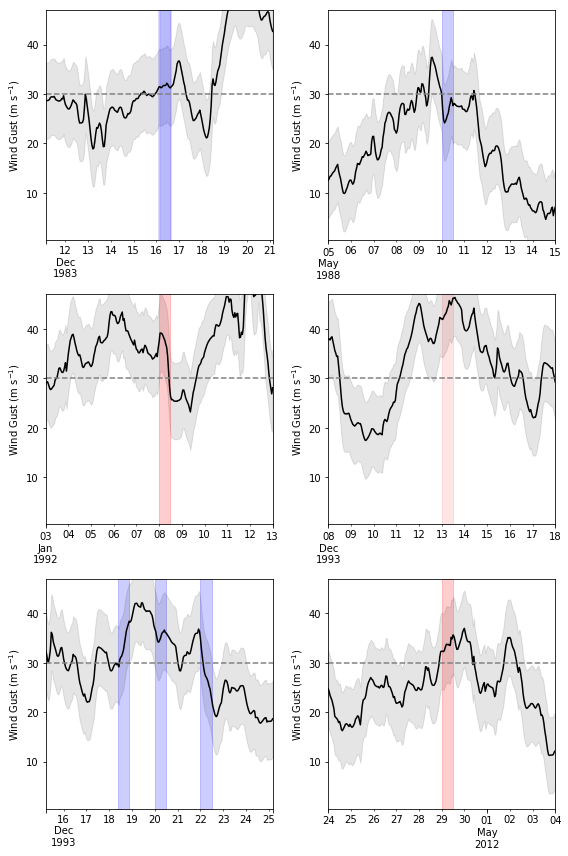

In [11]:
# Now we process the climbers' data
fin="/home/lunet/gytm3/Everest2019/Research/Weather/Data/himdata_data_updated.csv"
climbs=pd.read_csv(fin)
climbs["deathhgtm"]=climbs["deathhgtm"].astype(np.float)
# Extract summits and get dates into proper form
summits=climbs.loc[np.logical_and(climbs["success"]==1,climbs["death"]==0)]
summit_dates=himDate(summits["msmtdate1"],climbs["dsmttime1"],verb=False)
deaths=climbs.loc[climbs["deathhgtm"]>=8000] # High deaths only
missing=climbs.loc[np.logical_and(climbs["deathhgtm"]>=8000,climbs["deathtype"]==9)] # Deathtype = missing
fall_weather=climbs.loc[np.logical_and(climbs["deathhgtm"]>=8000,np.logical_and(climbs["deathtype"]==4,\
                                      climbs["weather"]==1))]
fall=climbs.loc[np.logical_and(climbs["deathhgtm"]>=8000,climbs["deathtype"]==4)]
fall_dates=himDate(fall["deathdate"],fall["ddthtime"],verb=False)
highs=climbs.loc[np.logical_and(climbs["death"]==0,climbs["mperhighpt"]>=8000)]
high_dates=himDate(highs["msmtdate1"],highs["dsmttime1"],verb=False)
# High fails, but survived)
turns=climbs.loc[np.logical_and(np.logical_and(climbs["mperhighpt"]>=8000,climbs["mperhighpt"]<8848),\
                             climbs["death"]==0)]
turn_dates=himDate(turns["msmtdate1"],turns["dsmttime1"],verb=False)
# Simply all above
all_above=climbs.loc[climbs["mperhighpt"]>=8000]
all_above_dates=himDate(all_above["msmtdate1"],all_above["dsmttime1"],verb=False)

weather_deaths=deaths.loc[deaths["weather"]==1] # Weather contributed to the death
death_dates=himDate(deaths["deathdate"],deaths["ddthtime"],verb=False) # Dates of deaths
missing_dates=himDate(missing["deathdate"],missing["ddthtime"],verb=True) # Dates of deaths
weather_dates=himDate(weather_deaths["deathdate"],weather_deaths["ddthtime"],verb=False) # Dates of deaths
fall_weather_dates=himDate(fall_weather["deathdate"],fall_weather["ddthtime"],verb=False) # Dates of fall+ weather deaths

# Atribute wind (max gust +/- 12 hours from time) during summit
summit_winds=match_winds(summit_dates,ug_recon,"mean",12,shift_time=-6)

# High winds -- ditto, but don't need to have summited. 
high_winds=match_winds(high_dates,ug_recon,"mean",12,shift_time=-6)

# Winds for those that turned around
turn_winds=match_winds(turn_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, but deaths
death_winds=match_winds(death_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, death by missing 
missing_winds=match_winds(missing_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, death by fall when weather was bad
fall_weather_winds=match_winds(fall_weather_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, but just a fall (not necessarily bad weather)
fall_winds=match_winds(fall_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, but all those above -- alive or dead
all_above_winds=match_winds(all_above_dates,ug_recon,"mean",12,shift_time=-6)


# Check the "narrow escapes"
narrow=highs.loc[high_winds.values[:]>30.];
highs.head(10); high_winds.head(10)
narrow_dates_init=himDate(narrow["msmtdate1"],narrow["dsmttime1"],verb=False)
narrow_dates_init = [ii-datetime.timedelta(hours=6) for ii in narrow_dates_init]
ref=pd.DataFrame(narrow)
ref.index=narrow_dates_init

#narrow["wind"]=high_winds[high_winds>30.]

# Get clusters from in amongst the narrow dates
# Note: returned value must be a dictionary with each of the unique dates as keys,
# and each of the corresponding summit dates/times as rows. 
narrow_dates,ids,max_hts=clusters(narrow_dates_init,5.,narrow["mperhighpt"])
# Convert narrow dates to UTC


# Now get the winds from +/- 72 hours of the clusters
narrow_winds={}
narrow_winds_upper={}
narrow_winds_lower={}
dt=datetime.timedelta(hours=120)
for i in narrow_dates:
    narrow_winds[i]=ug_recon.loc[np.logical_and(ug_recon.index>=i-dt,ug_recon.index<=i+dt)]
    narrow_winds_lower[i]=lower.loc[np.logical_and(lower.index>=i-dt,lower.index<=i+dt)]
    narrow_winds_upper[i]=upper.loc[np.logical_and(upper.index>=i-dt,upper.index<=i+dt)]
    
nplots=len(narrow_winds.keys())
fig,ax=plt.subplots(np.int(np.ceil(nplots/2.)),2)
fig.set_size_inches(8,12)
# reset datetime to be 12 hours
dt=datetime.timedelta(hours=12)
keys=np.sort(narrow_winds.keys())
spring_suc=[]; spring_fail=[]
spring_suc_wind=[]; spring_fail_wind=[]
wint_suc=[]; wint_fail=[]
wint_suc_wind=[]; wint_fail_wind=[]
for i in range(len(keys)):
    narrow_winds[keys[i]].plot(ax=ax.flat[i],color='k')
    ax.flat[i].fill_between(narrow_winds_lower[keys[i]].index,\
                            narrow_winds_lower[keys[i]].values[:],\
                            narrow_winds_upper[keys[i]].values[:],color='k',alpha=0.1)

    ax.flat[i].set_ylim(0.5,47)
    
    # Note: x has all the individual dates to go with the centre point
    x=ids[keys[i]][:]; 

    y=np.ones(len(x))*47.5
    
    # Iterate over the individual dates
    for j in range(len(x)):

        mz2=np.max(ref["mperhighpt"].loc[ref.index==x[j]]); 
        if mz2 == 8850: c="blue"
        else: c="red"
        ax.flat[i].fill_between([x[j],x[j],x[j]+dt,x[j]+dt],[0,47,47,0],color=c,alpha=0.1)
        print(x[j])
        if (x[j]).month==4 or (x[j]).month==5:
            
            if mz2 == 8850:
                if x[j] not in spring_suc: 
                    scratch=narrow_winds[keys[i]]
                    idx=np.logical_and(scratch.index>=x[j],\
                                       scratch.index<=x[j]+dt)
                    spring_suc_wind.append(np.mean(scratch.loc[idx])); 
                    spring_suc.append(x[j])
                    
            else:
                if x[j] not in spring_fail:                   
                    scratch=narrow_winds[keys[i]]
                    idx=np.logical_and(scratch.index>=x[j],\
                                       scratch.index<=x[j]+dt)
                    spring_fail_wind.append(np.mean(scratch.loc[idx])); 
                    spring_fail.append(x[j])
          
        if (x[j]).month==12 or (x[j]).month==1:
            
            if mz2 == 8850:
                if x[j] not in wint_suc: 
                    scratch=narrow_winds[keys[i]]
                    idx=np.logical_and(scratch.index>=x[j],\
                                       scratch.index<=x[j]+dt)
                    wint_suc_wind.append(np.mean(scratch.loc[idx])); 
                    wint_suc.append(x[j])
                    
            else:
                if x[j] not in wint_fail:                   
                    scratch=narrow_winds[keys[i]]
                    idx=np.logical_and(scratch.index>=x[j],\
                                       scratch.index<=x[j]+dt)
                    wint_fail_wind.append(np.mean(scratch.loc[idx])); 
                    wint_fail.append(x[j])
            
            
            
            if (x[j]).month==12 and (x[j]).year==1993 and (x[j]).day == 21:
                        print x[j]
                        scratch=narrow_winds[keys[i]]
                        scratch_lower=narrow_winds_lower[keys[i]]
                        scratch_upper=narrow_winds_upper[keys[i]]
                        idx=np.logical_and(scratch.index>=x[j],\
                                           scratch.index<=(x[j]+dt))

                        print("Mean wind = %.2f (%.2f-%.2f); max wind = %.2f(%.2f-%.2f) (all m/s)"%\
                              (np.mean(scratch.loc[idx]),\
                               np.mean(scratch_lower.loc[idx]),\
                               np.mean(scratch_upper.loc[idx]),\
                               np.max(scratch.loc[idx]),\
                               np.max(scratch_lower.loc[idx]),\
                               np.max(scratch_upper.loc[idx])))
                    
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("Wind Gust (m s$^{-1}$)")
    ax.flat[i].axhline(30,linestyle="--",color='grey')
    
plt.tight_layout()
fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Winds_during_climbs.png",dpi=300)

In [12]:
t,p=stats.ttest_ind(spring_suc_wind,spring_fail_wind)
print("Spring results...")
print(np.mean(spring_suc_wind),np.mean(spring_fail_wind))
print(t,p)

t,p=stats.ttest_ind(wint_suc_wind,wint_fail_wind)
print("Winter results...")
print(np.mean(wint_suc_wind),np.mean(wint_fail_wind))
print(t,p)


Spring results...
(26.775865289718901, 33.578756146900403)
(nan, nan)
Winter results...
(31.923728325634485, 39.795043418770717)
(-2.8289881138465662, 0.029997625087048039)


/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max for 5.00 percentile = 17.68
Max for 50.00 percentile = 34.79
Max for 75.00 percentile = 42.72
Max for 90.00 percentile = 49.77
Max for 99.00 percentile = 58.47
mu Delta survived: -2.49
mu Delta turned: -2.00
mu Delta missing: -2.00
mu Delta fell: -2.60
mu Delta all: -2.47
T-tests...
(-1.0655223309741721, 0.28681592114461013)
0.919997904258
(-0.050336232159038645, 0.9598613459551979)
(-0.076922755269758988, 0.93869569586970214)
(5.41823511160315, 6.9624365264599066e-08)
t,p for those who went > 8000 = -23.32, 0.00
-2.47453035029
Mean high winds = 12.88
99th high winds = 27.30
(Timestamp('1983-12-16 08:00:00'), ': mu = 30.8 [23.1-38.5]')
(Timestamp('1983-12-16 09:00:00'), ': mu = 30.8 [23.1-38.5]')
(Timestamp('1983-12-16 10:00:00'), ': mu = 30.9 [23.2-38.6]')
(Timestamp('1988-05-10 06:00:00'), ': mu = 30.5 [22.8-38.2]')
(Timestamp('1992-01-08 06:00:00'), ': mu = 35.2 [27.5-42.9]')
(Timestamp('1993-12-13 06:00:00'), ': mu = 41.6 [33.9-49.3]')
(Timestamp('1993-12-18 15:00:00'), ': mu =

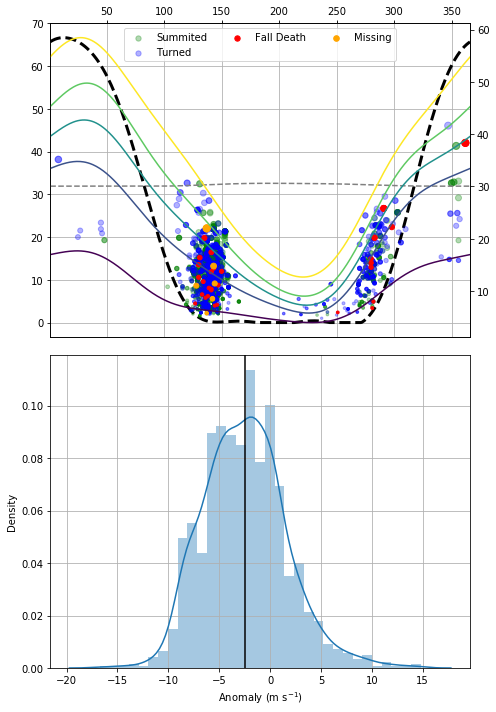

In [13]:
# Plots and climatology (max winds +/- 12 hours)
color=cm.viridis(np.linspace(0,1,len(pctls)))
fig,ax=plt.subplots(2,1)
fig.set_size_inches(7,10)
month_dug_s.plot(ax=ax.flat[0],color='k',linestyle='--',linewidth=3);
ax2=ax.flat[0].twinx()
month_urc.plot(ax=ax2,color='grey',linestyle='--',linewidth=1.5,label="")
#month_dug.plot(ax=ax)
vs=mon_stats.columns
for i in range(len(vs)): 
    y=mon_stats[vs[i]]
    y.plot(ax=ax2,c=color[i],label="")
    print("Max for %.2f percentile = %.2f" % (vs[i],np.max(y) ))

a1=ax2.scatter(summit_winds.index.dayofyear,summit_winds.values[:],color='green',alpha=0.3,\
            s=summit_winds.values[:]/np.nanmax(summit_winds)*50,label="Summited")
a5=ax2.scatter(turn_winds.index.dayofyear,turn_winds.values[:],color='blue',alpha=0.3,\
            s=turn_winds.values[:]/np.nanmax(turn_winds)*50,label="Turned")
#a1=ax2.scatter([0,],[100,],color='grey',alpha=1,label="Survived")
#a2=ax2.scatter(death_winds.index.dayofyear,death_winds.values[:],color='red',alpha=1,\
#           s=death_winds.values[:]/np.nanmax(death_winds)*50,label="Death")
a3=ax2.scatter(fall_winds.index.dayofyear,fall_winds.values[:],color='red',alpha=1,\
            s=fall_winds.values[:]/np.nanmax(fall_winds)*50,label="Fall Death")
a4=ax2.scatter(missing_winds.index.dayofyear,missing_winds.values[:],color='orange',alpha=1,\
            s=missing_winds.values[:]/np.nanmax(missing_winds)*50,label="Missing")


#fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Wind_Climatology_climbs.tiff",dpi=300)

# Re-extract the high winds -- but this time focussing on the mean
high_winds=match_winds(high_dates,ug_recon,"mean",12,shift_time=-6)
high_winds_lower=match_winds(high_dates,lower,"mean",12,shift_time=-6); 
high_winds_upper=match_winds(high_dates,upper,"mean",12,shift_time=-6)

# Ditto, but survived and turned around
turn_winds=match_winds(turn_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, death by missing 
missing_winds=match_winds(missing_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, but just a fall 
fall_winds=match_winds(fall_dates,ug_recon,"mean",12,shift_time=-6)

# Ditto, but all those above -- alive or dead
all_above_winds=match_winds(all_above_dates,ug_recon,"mean",12,shift_time=-6)
all_above_thresh=match_winds(all_above_dates,ur_c,"mean",12,shift_time=-6)

# Clean all -- remove NaN and drop duplicates
high_winds=high_winds.dropna().sort_index().drop_duplicates()
high_winds_lower=high_winds_lower.dropna().sort_index().drop_duplicates()
high_winds_upper=high_winds_upper.dropna().sort_index().drop_duplicates()
fall_winds=fall_winds.dropna().sort_index().drop_duplicates()
death_winds=death_winds.dropna().sort_index().drop_duplicates()
all_above_winds=all_above_winds.dropna().sort_index().drop_duplicates()
all_above_thresh=all_above_thresh.dropna().sort_index().drop_duplicates()
turn_winds=turn_winds.dropna().sort_index().drop_duplicates()
summit_winds=summit_winds.dropna().sort_index().drop_duplicates()


# Subtract
delta_high=high_winds-mean.loc[mean.index.isin(high_winds.index)]; print("mu Delta survived: %.2f"%np.nanmean(delta_high))
delta_turn=turn_winds-mean.loc[mean.index.isin(turn_winds.index)]; print("mu Delta turned: %.2f"%np.nanmean(delta_turn))
delta_missing=missing_winds-mean.loc[mean.index.isin(missing_winds.index)]; print("mu Delta missing: %.2f"%np.nanmean(delta_missing))
delta_fall=fall_winds-mean.loc[mean.index.isin(fall_winds.index)]; print("mu Delta fell: %.2f"%np.nanmean(delta_fall))
delta_all_above=all_above_winds-mean.loc[mean.index.isin(all_above_winds.index)]; print("mu Delta all: %.2f"%np.nanmean(delta_all_above))

# t-tests
print( "T-tests...")
t,p=stats.ttest_ind(high_winds[~np.isnan(high_winds)], fall_winds[~np.isnan(fall_winds)]); print(t,p)
print(np.mean(fall_winds[~np.isnan(fall_winds)])-np.mean(high_winds[~np.isnan(high_winds)]))
t,p=stats.ttest_ind(high_winds[~np.isnan(high_winds)], fall_winds[np.logical_and(~np.isnan(fall_winds),fall_winds<30)]); print(t,p)
t,p=stats.ttest_ind(high_winds[~np.isnan(high_winds)], missing_winds[~np.isnan(missing_winds)]); print(t,p)
t,p=stats.ttest_ind(turn_winds[~np.isnan(turn_winds)], summit_winds[~np.isnan(summit_winds)]); print(t,p)
# Print one-sample t-test for high_winds
t,p=stats.ttest_1samp(delta_all_above[~np.isnan(delta_all_above)],0)
print("t,p for those who went > 8000 = %.2f, %.2f"%(t,p))

# Second plot
sns.distplot(delta_all_above,ax=ax.flat[1])
ax.flat[1].set_xlabel("Anomaly (m s$^{-1})$")
ax.flat[1].set_ylabel("Density")
ax.flat[1].grid()
ax.flat[1].axvline(delta_high.mean(),color='k')
ax.flat[0].xaxis.tick_top()
ax.flat[0].xaxis.set_label_position("top")
print(np.mean(delta_all_above))
ax.flat[0].grid()

ax.flat[0].xaxis.set_label("Day of Year")
ax2.legend(loc=9,ncol=3)
plt.tight_layout()
fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Wind_Climatology_climbs.tiff",dpi=300)

# Summary of winds during high episodes
print("Mean high winds = %.2f"%np.mean(high_winds))
print("99th high winds = %.2f"%np.percentile(high_winds,99))

# Really fast winds?
for i in range(len(high_winds)):
    if high_winds.values[i]>30:
        print(high_winds.index[i], ": mu = %.1f [%.1f-%.1f]" %(high_winds.values[i],high_winds_lower.values[i],\
                                                high_winds_upper.values[i]))
print(high_winds.loc[high_winds>30])
                                                                              
# How many (%) of all_above experienced winds above threshold
print("Of all climbs, %.2f%% took place with a mean gust below threshold"%\
      (np.sum((all_above_winds-all_above_thresh)<0)/np.float(len(all_above_thresh))*100))   
#print("Of all climbs, %.2f%% took place with a mean gust below threshold"%\
#      (np.sum((all_above_winds-30.4)<0)/np.float(len(all_above_thresh))*100))      

In [14]:
# Missing and fall dates >27.5
missing_winds=match_winds(missing_dates,ug_recon,"max",12,shift_time=-6)
fast_missing=missing.loc[missing_winds.values[:]>26];
fast_missing_dates=himDate(fast_missing["deathdate"],fast_missing["ddthtime"],verb=False)

# Now get the winds from +/- 72 hours of the clusters
fast_missing_winds={}
dt=datetime.timedelta(hours=72)
nplots=len(np.unique(fast_missing_dates))
fig,ax=plt.subplots(np.int(np.ceil(nplots/1.)),1)
for i in np.unique(fast_missing_dates):
    fast_missing_winds[i]=ug_recon.loc[np.logical_and(ug_recon.index>=i-dt,ug_recon.index<=i+dt)]
    x=fast_missing_winds[i].index; print(x.shape)
    ax.plot(x,fast_missing_winds[i].values[:])
    dt=datetime.timedelta(hours=24)
    ax.fill_between([i,i,i+dt,i+dt],[0,45,45,0],color=c,alpha=0.1)
    
#  fall dates >30
fall_winds=match_winds(fall_dates,ug_recon,"max",12,shift_time=-6)
fast_fall=fall.loc[fall_winds.values[:]>35];
fast_fall_dates=himDate(fast_fall["deathdate"],fast_fall["ddthtime"],verb=False)



/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


<Figure size 432x288 with 0 Axes>

Mean Kato (summit)  = 34.1 (26.3-41.8) m/s 
Mean Kato (radio)  = 35.8 (28.0-43.5) m/s 
Max '96:  = 19.3 (11.6-27.0) m/s 
Mean Kato (night)  = 37.5 (29.8-45.2) m/s 
Max Kato (night)  = 41.1 (33.4-48.8) m/s 
41.1772514008


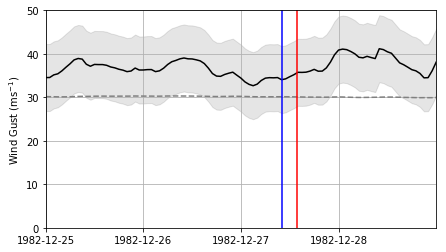

In [15]:
# Plot the winds during the kato and kobayash incident, and during the Boardmann/Tasker incident
# Set up for Japanese
st=datetime.datetime(year=1982,month=12,day=25)
stp=datetime.datetime(year=1982,month=12,day=29)
trans=datetime.datetime(year=1982,month=12,day=27,hour=19,minute=30)-datetime.timedelta(hours=5,minutes=45)
summit=datetime.datetime(year=1982,month=12,day=27,hour=15,minute=55)-datetime.timedelta(hours=5,minutes=45)
trace_jap=ug_recon[np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)]
trace_jap_lower=lower[np.logical_and(lower.index>=st,lower.index<=stp)]
trace_jap_upper=upper[np.logical_and(upper.index>=st,upper.index<=stp)]
trace_urc_jap=ur_c[np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)]


st_summit=datetime.datetime(year=1982,month=12,day=27,hour=15,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp_summit=datetime.datetime(year=1982,month=12,day=27,hour=16,minute=0)-datetime.timedelta(hours=5,minutes=45)
idx_summit=np.logical_and(ug_recon.index>=st_summit,ug_recon.index<=stp_summit)
summit=np.mean(ug_recon[idx_summit])
summit_lower=np.mean(lower[idx_summit])
summit_upper=np.mean(upper[idx_summit])
print("Mean Kato (summit)  = %.1f (%.1f-%.1f) m/s "%\
      (summit,summit_lower,summit_upper))

st_radio=datetime.datetime(year=1982,month=12,day=27,hour=19,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp_radio=datetime.datetime(year=1982,month=12,day=27,hour=20,minute=0)-datetime.timedelta(hours=5,minutes=45)
idx_radio=np.logical_and(ug_recon.index>=st_radio,ug_recon.index<=stp_radio)
radio=np.mean(ug_recon[idx_radio])
radio_lower=np.mean(lower[idx_radio])
radio_upper=np.mean(upper[idx_radio])
print("Mean Kato (radio)  = %.1f (%.1f-%.1f) m/s "%\
      (radio,radio_lower,radio_upper))

st_96=datetime.datetime(year=1996,month=5,day=10,hour=0,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp_96=datetime.datetime(year=1996,month=5,day=11,hour=23,minute=0)-datetime.timedelta(hours=5,minutes=45)
idx_96=np.logical_and(ug_recon.index>=st_96,ug_recon.index<=stp_96)
mu96=np.max(ug_recon[idx_96])
lower96=np.max(lower[idx_96])
upper96=np.max(upper[idx_96])
print("Max '96:  = %.1f (%.1f-%.1f) m/s "%\
      (mu96,lower96,upper96))


st_night=datetime.datetime(year=1982,month=12,day=27,hour=20,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp_night=datetime.datetime(year=1982,month=12,day=28,hour=7,minute=0)-datetime.timedelta(hours=5,minutes=45)
idx_night=np.logical_and(ug_recon.index>=st_night,ug_recon.index<=stp_night)
night=np.mean(ug_recon[idx_night])
night_lower=np.mean(lower[idx_night])
night_upper=np.mean(upper[idx_night])
print("Mean Kato (night)  = %.1f (%.1f-%.1f) m/s "%\
      (night,night_lower,night_upper))
night=np.max(ug_recon[idx_night])
night_lower=np.max(lower[idx_night])
night_upper=np.max(upper[idx_night])
print("Max Kato (night)  = %.1f (%.1f-%.1f) m/s "%\
      (night,night_lower,night_upper))

# Set up plot
fig,ax=plt.subplots(1,1)
fig.set_size_inches(7,4)
myFmt = mdates.DateFormatter('%Y-%m-%d')


# Plot Jap
ax.plot(trace_jap,color='k')
ax.plot(trace_urc_jap,color='grey',linestyle='--')
summit=datetime.datetime(year=1982,month=12,day=27,hour=15,minute=55)-datetime.timedelta(hours=5,minutes=45)
ax.axvline(summit,color='blue')
ax.axvline(trans,color='red')
ax.fill_between(trace_jap_lower.index,trace_jap_lower.values[:],trace_jap_upper.values[:],color='k',\
                       alpha=0.1)
print(np.max(trace_jap))
ax.grid()
ax.set_ylabel("Wind Gust (ms$^{-1}$)")
ax.set_xlim(st,stp)
ticks = ax.get_xticks()
ax.set_xticks(ticks[0:-1:2])
ax.set_ylim(0,50)
ax.xaxis.set_major_formatter(myFmt)

fig.savefig("/home/lunet/gytm3/Everest2019/Research/Weather/Figures/Japanese_Winds.png")


In [16]:
#summit_wind=trace[abs(trace.index-summit)==min(abs(trace.index-summit))].values[0]
#max_wind=np.max(trace)
#print(summit_wind)
#print(max_wind)
#print(max_wind/summit_wind)
#print("dw=%.2f times stronger"%(max_wind/summit_wind)**2)
#print("dw=%.2f times more KE"%(max_wind/summit_wind)**3)
#ticks

In [17]:
# Conditions during the summit successful summit of Ogata (1995)
st=datetime.datetime(year=1993,month=12,day=22,hour=9,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp=datetime.datetime(year=1993,month=12,day=22,hour=11,minute=0)-datetime.timedelta(hours=5,minutes=45)
day_idx=np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)
print(ug_recon[day_idx])
ogata=np.mean(ug_recon[day_idx])
ogata_lower=np.mean(lower[day_idx])
ogata_upper=np.mean(upper[day_idx])
print("Mean Ogata (South Summit-Summit)  = %.1f (%.1f-%.1f) m/s "%\
      (ogata,ogata_lower,ogata_upper))

st=datetime.datetime(year=1993,month=12,day=20,hour=9,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp=datetime.datetime(year=1993,month=12,day=20,hour=12,minute=0)-datetime.timedelta(hours=5,minutes=45)
day_idx=np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)
print(ug_recon[day_idx])
tanabe=np.mean(ug_recon[day_idx])
tanabe_lower=np.mean(lower[day_idx])
tanabe_upper=np.mean(upper[day_idx])
print("Mean Tanabe and Ezuka (South Summit-Summit) = %.1f (%.1f-%.1f) m/s "%\
      (tanabe,tanabe_lower,tanabe_upper))


st=datetime.datetime(year=1993,month=12,day=18,hour=13,minute=0)-datetime.timedelta(hours=5,minutes=45)
stp=datetime.datetime(year=1993,month=12,day=18,hour=16,minute=0)-datetime.timedelta(hours=5,minutes=45)
day_idx=np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)
print(ug_recon[day_idx])
tanabe=np.mean(ug_recon[day_idx])
tanabe_lower=np.mean(lower[day_idx])
tanabe_upper=np.mean(upper[day_idx])
print("Mean Nazuka (South Summit-Summit) = %.1f (%.1f-%.1f) m/s "%\
      (tanabe,tanabe_lower,tanabe_upper))

# Conditions during the disappearance of Seamus Lawless?
st=datetime.datetime(year=2019,month=5,day=16,hour=0)-datetime.timedelta(hours=5,minutes=45)
stp=datetime.datetime(year=2019,month=5,day=17,hour=0)-datetime.timedelta(hours=5,minutes=45)
day_idx=np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)

seamus=np.max(ug_recon[day_idx])
seamus_lower=np.max(lower[day_idx])
seamus_upper=np.max(upper[day_idx])
z=ug_recon[np.logical_and(ug_recon.index.month==5,ug_recon.index.day==16)].values[:]
pctl=stats.percentileofscore(high_winds,np.max(ug_recon[day_idx]))
print("Max wind (Seamus) = %.1f m/s (%.1f - %.1f m/s) [~the %.2f percentile]"%\
      (seamus,seamus_lower,seamus_upper,pctl))


time
1993-12-22 04:00:00    28.231669
1993-12-22 05:00:00    27.474800
dtype: float64
Mean Ogata (South Summit-Summit)  = 27.9 (20.1-35.6) m/s 
time
1993-12-20 04:00:00    34.148597
1993-12-20 05:00:00    34.527412
1993-12-20 06:00:00    35.025625
dtype: float64
Mean Tanabe and Ezuka (South Summit-Summit) = 34.6 (26.9-42.3) m/s 
time
1993-12-18 08:00:00    29.584487
1993-12-18 09:00:00    29.856782
1993-12-18 10:00:00    29.168496
dtype: float64
Mean Nazuka (South Summit-Summit) = 29.5 (21.8-37.2) m/s 
Max wind (Seamus) = 19.0 m/s (11.3 - 26.7 m/s) [~the 90.92 percentile]


In [18]:
# Conditions during the disappearance of Phil Crampton?
st=datetime.datetime(year=2009,month=5,day=19,hour=0)-datetime.timedelta(hours=5,minutes=45)
stp=datetime.datetime(year=2009,month=5,day=20,hour=0)-datetime.timedelta(hours=5,minutes=45)
day_idx=np.logical_and(ug_recon.index>=st,ug_recon.index<=stp)

phil=np.max(ug_recon[day_idx])
phil_lower=np.max(lower[day_idx])
phil_upper=np.max(upper[day_idx])
z=ug_recon[np.logical_and(ug_recon.index.month==5,ug_recon.index.day==19)].values[:]
pctl=stats.percentileofscore(high_winds,np.max(ug_recon[day_idx]))
print("Max wind (Phil) = %.1f m/s (%.1f - %.1f m/s) [~the %.2f percentile]"%\
      (phil,phil_lower,phil_upper,pctl))

Max wind (Phil) = 11.9 m/s (4.2 - 19.6 m/s) [~the 45.04 percentile]


In [19]:
#Mean JD, spring = 138 (108-168)
#Mean JD, aut = 277 (247-307)
len(all_above_winds)

1463

In [20]:
len(upper)

359400